# Getaround Analysis
## Objective: Minimize delay between two car rentals. 
- Create a web dashboard to support decisionmakers to analyze data.
- Choose an ideal threshold to help product manager decide:
    - threshold: length of delay
    - scope: what cars should the treshold be applied on?
- Create an API that serves a machine learning algorithm to suggest optimal rental prices to owners.
- Host API in an online server.

## Imports

In [1]:
# data handling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# feature engineering and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# save model
import pickle
import joblib

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# data used for analysis
delay = pd.read_excel("Data/get_around_delay_analysis.xlsx")
df = delay.copy()

# data used for machine learning
pricing = pd.read_csv("Data/get_around_pricing_project.csv")

In [3]:
df.head(5)

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [4]:
pricing.head(5)

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


## Exploratory Data Analysis

### _delay_ Dataset
Documentation:
- rental_id: Unique identifier of the rental

- car_id - Unique identifier of the car
- checkin_type - Flow used for both checkin and checkout. (ie. access and return the car)

        - mobile = rental agreement signed on the owner's smartphone
        - connect = car equiped with the Connect technology , opened by the driver with his smartphone.
        
        Note: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible 
        use case
- state - canceled means that the rental did not happen (was canceled by the driver or the owner).

- delay_at_checkout_in_minutes - Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. 

        - Negative values mean that the driver returned the car in advance.

- previous_ended_rental_id - id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)

- time_delta_with_previous_rental_in_minutes - Difference in minutes between this rental planned start time and the previous rental planned end time

        - Appears when lower than 12 hours
        - NULL if higher

#### Feature Engineering

In [5]:
print("rows:", df.shape[0], "\ncolumns:", df.shape[1])

rows: 21310 
columns: 7


In [6]:
# duplicated values
df.duplicated().sum()

0

In [7]:
# percentage of missing values
df.isna().sum() / len(df)

rental_id                                     0.000000
car_id                                        0.000000
checkin_type                                  0.000000
state                                         0.000000
delay_at_checkout_in_minutes                  0.232942
previous_ended_rental_id                      0.913609
time_delta_with_previous_rental_in_minutes    0.913609
dtype: float64

- Too many missing values for last two variables

In [8]:
# rename columns that are too long
df.rename(columns={"delay_at_checkout_in_minutes":"delay_minutes",
                   "time_delta_with_previous_rental_in_minutes": "difference_rentals_minutes"}, inplace=True)

In [9]:
# sample of dataframe without missing values
df.dropna(subset=["difference_rentals_minutes", \
                  "previous_ended_rental_id"]).head(5)

,rental_id,car_id,checkin_type,state,delay_minutes,previous_ended_rental_id,difference_rentals_minutes
6,511639,370585,connect,ended,-15.0,563782.0,570.0
19,519491,312389,mobile,ended,58.0,545639.0,420.0
23,521156,392479,mobile,ended,NaN,537298.0,0.0
34,525044,349751,mobile,ended,NaN,510607.0,60.0
40,528808,181625,connect,ended,-76.0,557404.0,330.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   rental_id                   21310 non-null  int64  
 1   car_id                      21310 non-null  int64  
 2   checkin_type                21310 non-null  object 
 3   state                       21310 non-null  object 
 4   delay_minutes               16346 non-null  float64
 5   previous_ended_rental_id    1841 non-null   float64
 6   difference_rentals_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


In [11]:
# change objects to categories
df[["checkin_type", "state"]] = df[["checkin_type", "state"]].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   rental_id                   21310 non-null  int64   
 1   car_id                      21310 non-null  int64   
 2   checkin_type                21310 non-null  category
 3   state                       21310 non-null  category
 4   delay_minutes               16346 non-null  float64 
 5   previous_ended_rental_id    1841 non-null   float64 
 6   difference_rentals_minutes  1841 non-null   float64 
dtypes: category(2), float64(3), int64(2)
memory usage: 874.4 KB


#### Distributions and Relationships

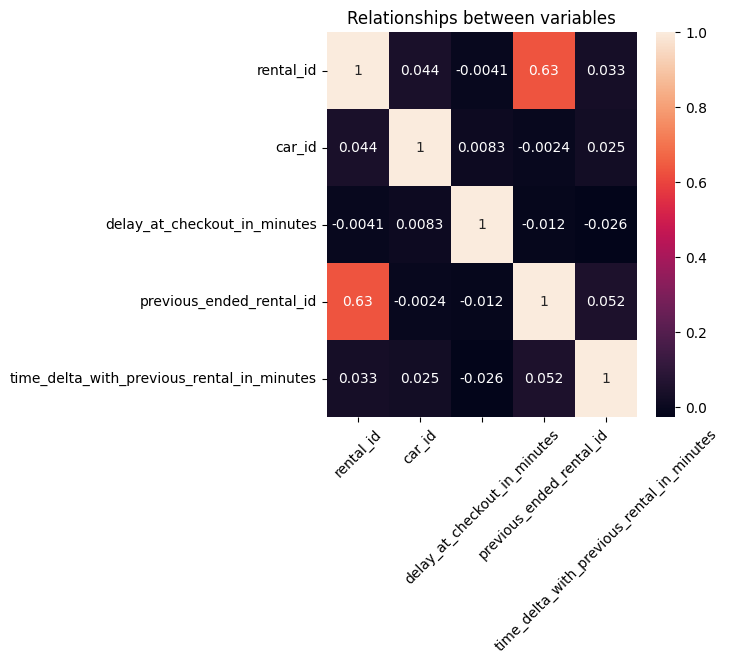

In [12]:
# correlation analysis
plt.figure(figsize=(5,5))
plt.title("Relationships between variables")
sns.heatmap(delay.select_dtypes(include="number").corr(), annot=True)
plt.xticks(rotation=45)
plt.show()

##### Insight
- No significant relationships (except for ID's, but irrelevant)

checkin_type
mobile     0.798
connect    0.202
Name: proportion, dtype: float64

<Figure size 800x400 with 0 Axes>

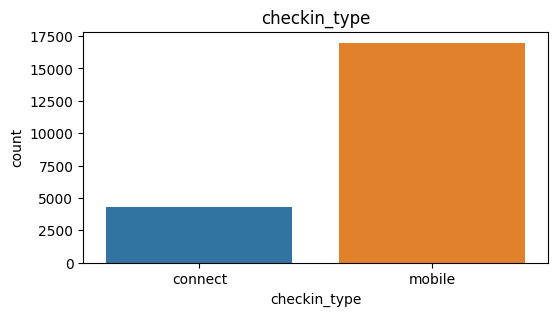

state
ended       0.847
canceled    0.153
Name: proportion, dtype: float64

<Figure size 800x400 with 0 Axes>

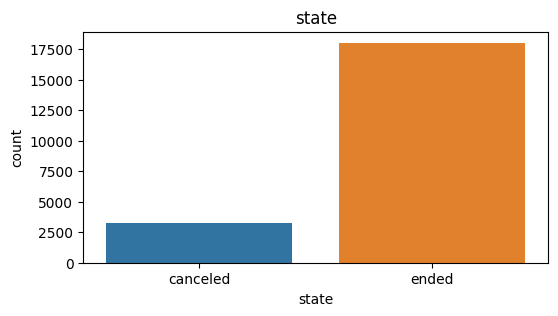

In [13]:
cols = ["checkin_type", "state"]

# for loop to display value counts and make a countplot
for col in cols:
    plt.figure(figsize=(8,4))
    display(df[col].value_counts(1).round(3))
    plt.figure(figsize=(6,3))
    sns.countplot(data=df,
                  x=col)
    plt.title(col)
    plt.show()

In [14]:
df.head()

,rental_id,car_id,checkin_type,state,delay_minutes,previous_ended_rental_id,difference_rentals_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


### 

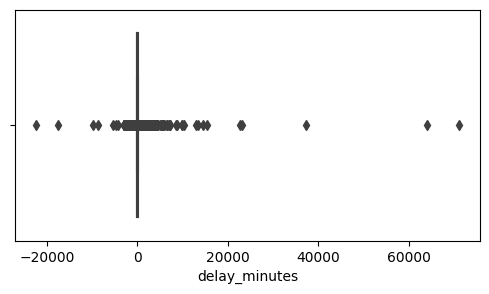

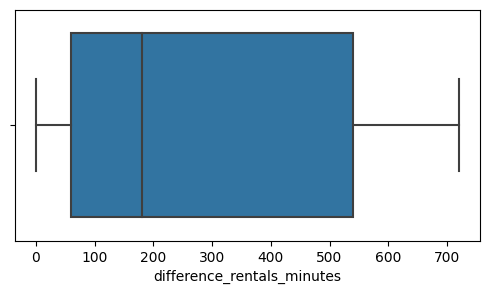

In [15]:
# for loop to plot distributions for selected variables

cols = ["delay_minutes", "difference_rentals_minutes"]
for col in cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.show()

##### Insight
- *delay_at_checkout_in_minutes* and *delay_minutes_ have way too many outliers, it is not normal to have this amount of outliers.

- All of them cannot be removed as they are an integral piece of data, but those that were higher than 1.5 times the Inter Quartile Range were removed, as they are very extreme values.
- As we have many outliers median will be used, not mean, for calculations.

In [16]:
# create dataframe without missing values on "delay_minutes" and "difference_rentals_minutes"
# in order to do calculations with them 

# "dataframe without nans"
df_wo_nan = df.dropna(subset=["delay_minutes"])
df_wo_nan.head()

,rental_id,car_id,checkin_type,state,delay_minutes,previous_ended_rental_id,difference_rentals_minutes
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
5,511626,398802,mobile,ended,-203.0,NaN,NaN
6,511639,370585,connect,ended,-15.0,563782.0,570.0
7,512303,371242,mobile,ended,-44.0,NaN,NaN


In [17]:
# outliers
Q1 = np.percentile(df_wo_nan["delay_minutes"], 25)
Q3 = np.percentile(df_wo_nan["delay_minutes"], 75)
IQR = Q3 - Q1
print("Q1:", Q1)
print("Q3:", Q3)
print("IQR range:", IQR)

Q1: -36.0
Q3: 67.0
IQR range: 103.0


In [18]:
# set upper and lower thresholds for outliers
upper_whisker = Q3 +1.5*IQR
lower_whisker = Q1 - 1.5*IQR
print("upper whisker:", upper_whisker)
lower_whisker = Q1 - 1.5*IQR
print("lower whisker:", lower_whisker)

upper whisker: 221.5
lower whisker: -190.5


In [19]:
# remove outliers that are more than 1.5 times away from IQR
df_wo_outliers = df_wo_nan[(df_wo_nan["delay_minutes"] >= lower_whisker) & (df_wo_nan["delay_minutes"] <= upper_whisker)]
df_wo_outliers.head()

,rental_id,car_id,checkin_type,state,delay_minutes,previous_ended_rental_id,difference_rentals_minutes
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
6,511639,370585,connect,ended,-15.0,563782.0,570.0
7,512303,371242,mobile,ended,-44.0,NaN,NaN
9,513434,256528,connect,ended,23.0,NaN,NaN


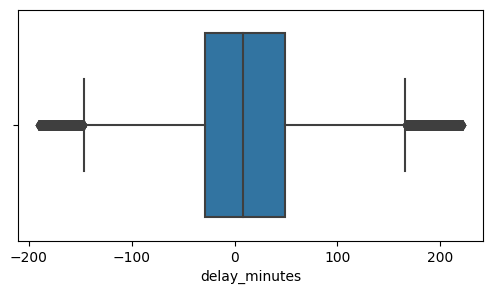

In [20]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_wo_outliers["delay_minutes"])
plt.show()

#### 

In [21]:
# median difference between  
checkin_type = ["connect", "mobile"]

# encode variables, to shorten and make text more readable
col1 = "checkin_type"
col2 = "difference_rentals_minutes"

for checkin in checkin_type:
    print(f'Median difference between rentals for {checkin}: {df_wo_nan[df_wo_nan[col1]==checkin][col2].median().round(2)} minutes')


Median difference between rentals for connect: 180.0 minutes
Median difference between rentals for mobile: 180.0 minutes


##### Insight
- No difference at all, it is a non-factor.

In [22]:
# median delay for each checkin type
checkin_types = ["connect", "mobile"]

for checkin in checkin_types:
    print(f'Median delay for {checkin}:\n\
          {df_wo_outliers[df_wo_outliers["checkin_type"]==checkin]["delay_minutes"].median().round(2)} minutes')


Median delay for connect:
          -5.0 minutes
Median delay for mobile:
          10.0 minutes


##### Insight
- Check ins that are made with connect arrive 8 minutes in advance, while those made with mobile arrived 9 minutes in delay.
- An interesting question: Is it worth it to make the transfer to _Connect_ technology? If so, how can we incentivize car owners to start using it?

In [23]:
# what percentage of cars have Connect technology
pricing["has_getaround_connect"].value_counts(1).round(2)

has_getaround_connect
False    0.54
True     0.46
Name: proportion, dtype: float64

In [24]:
col1 = "has_getaround_connect"
col2 = "rental_price_per_day" 
values = [0, 1]

for value in values:
    print(f"Has Connect technology: {value},\n Median rental price: {pricing[pricing[col1]==value][col2].median().round(2)}")

Has Connect technology: 0,
 Median rental price: 110.0
Has Connect technology: 1,
 Median rental price: 130.0


##### Insight
- It is surprising to see that even though almost half of cars have _Connect_ technology only 10% of check ins are made this way. 
- Price might also have an influence as it is on average (median) $20 more expensive, than cars that do not have _Connect_.

### Questions
- Which share of our owner’s revenue would potentially be affected by the feature?
- How often are drivers late for the next check-in? How does it impact the next driver?
- How many rentals would be affected by the feature depending on the threshold and scope we choose?
- How many problematic cases will it solve depending on the chosen threshold and scope?

In [25]:
df_wo_outliers["delay_minutes"].median()

8.0

In [26]:
# amount of observations where there is a delay, divided by whole data
perc_time_cars_late = len(df_wo_outliers[df_wo_outliers["delay_minutes"] > 0]) / len(df_wo_outliers)
print(f"Percentage of time cars are returned late: {100* round(perc_time_cars_late, 3)}%")

Percentage of time cars are returned late: 57.199999999999996%


In [27]:
median_min_diff = (df_wo_outliers["difference_rentals_minutes"].median().round())
median_hr_diff = (df_wo_outliers["difference_rentals_minutes"].median()/ 60).round(2)

print(f"Median difference between end of rental and next programmed check in: \n{median_hr_diff} hours\n{median_min_diff} minutes")

Median difference between end of rental and next programmed check in: 
3.0 hours
180.0 minutes


In [28]:
# what percentage of delays are greater than the median difference between end of rental and programmed check in?
# in other words, considering the median difference of rentals as a threshold, how many checkins were affected?

median_diff_rentals = df_wo_outliers["difference_rentals_minutes"].median()

affected_drivers_perc = round((df_wo_outliers[df_wo_outliers["delay_minutes"] > median_diff_rentals].shape[0]\
        / len(df_wo_outliers)),5)*100

print(f"If using median difference of time between rentals as a threshold, which is {median_diff_rentals.round(2)},")
print(f"{affected_drivers_perc}% of checkins were delayed. This could serve as a good threshold, but time could be shortened.")
print("\nWe have to find a balance between two variables: difference between time between rentals \
      \nand quantity of rentals to maximize revenue for car owners.")

If using median difference of time between rentals as a threshold, which is 180.0,
2.2849999999999997% of checkins were delayed. This could serve as a good threshold, but time could be shortened.

We have to find a balance between two variables: difference between time between rentals       
and quantity of rentals to maximize revenue for car owners.


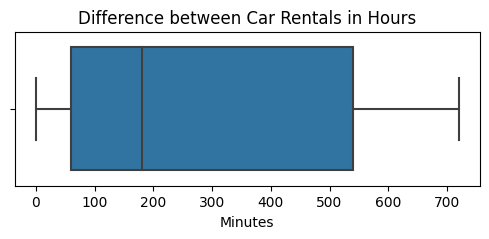

In [29]:
plt.figure(figsize=(6,2))
sns.boxplot(x=df_wo_outliers["difference_rentals_minutes"])
plt.xlabel("Minutes")
plt.title("Difference between Car Rentals in Hours")
plt.show()

In [30]:
# when there is a delay, what percent of data falls on each threshold? 

percentiles_delay = {}
# 10 to 100, steps of 10
for percentile in range(10,110,10):
    percentiles_delay[percentile] = \
        np.percentile(df_wo_outliers[df_wo_outliers["delay_minutes"]>0]["delay_minutes"], percentile).round(2)

percentiles_delay

{10: 6.0,
 20: 12.0,
 30: 19.0,
 40: 29.0,
 50: 40.0,
 60: 55.0,
 70: 73.0,
 80: 98.0,
 90: 139.0,
 100: 221.0}

<Axes: xlabel='delay_minutes', ylabel='Count'>

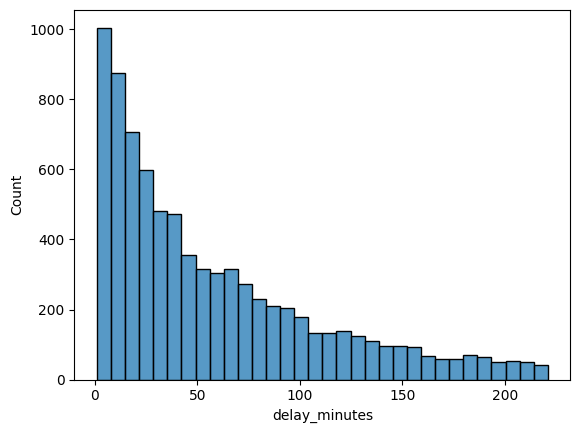

In [31]:
sns.histplot(df_wo_outliers[df_wo_outliers["delay_minutes"]>0]["delay_minutes"])

In [32]:
df_wo_outliers["late"] = np.where(df_wo_outliers["delay_minutes"]<=0, "Early", "Late")
df_wo_outliers["late"]

1        Early
2         Late
6        Early
7        Early
9         Late
         ...  
21303     Late
21304    Early
21307     Late
21308    Early
21309     Late
Name: late, Length: 13916, dtype: object

In [33]:
# download data wuthout outliers
# save to Data folder
df_wo_outliers.to_excel("Data/df_wo_outliers.xlsx")

In [34]:
percentiles_delay = {}
for percentile in range(10,110,10):
    percentiles_delay[percentile] = \
        np.percentile(df_wo_outliers[df_wo_outliers["delay_minutes"]>0]["delay_minutes"], percentile)
    
# convert to dataframe    
thresholds = pd.DataFrame.from_dict(percentiles_delay, orient="index").reset_index()
thresholds.rename(columns={"index": "Percentage of Delays",
                           0: "Minutes Threshold"},
                           inplace=True)

thresholds



,Percentage of Delays,Minutes Threshold
0,10,6.0
1,20,12.0
2,30,19.0
3,40,29.0
4,50,40.0
5,60,55.0
6,70,73.0
7,80,98.0
8,90,139.0
9,100,221.0


In [35]:
thresholds["Minutes Threshold"]

0      6.0
1     12.0
2     19.0
3     29.0
4     40.0
5     55.0
6     73.0
7     98.0
8    139.0
9    221.0
Name: Minutes Threshold, dtype: float64

In [36]:
thresholds.to_excel("thresholds.xlsx", index=False)

In [37]:
import plotly.express as px

delay = df_wo_outliers[df_wo_outliers["delay_minutes"]>0]
labels = {"delay_minutes":"Delay in Minutes"}
fig3 = px.histogram(delay, x="delay_minutes",
                    labels=labels)
fig3.show()

##### Insight
How to read: $x$ percent of data falls before $y$ threshold
Example: 10% of data falls before 6.2 and 90% after it.
    
- Some possible thresholds might be 87 (80th percentile) and 124 (90th percentiles)

    - If we set a threshold of 124 minutes, or 2 hours and 4 minutes, only 10% of check ins will be on delay.
    - If we set a threshold of 87 minutes, or 1 hour and 27 minutes, 20% of check ins will be on delay.

- The current percentage of late arrivals is 52.7%, this rate could be reduced by:
    - 124 as threshold: -42.7%
    - 87 as threshold: - 32.7%

### Chosen Threshold
##### The chosen threshold will be of 120 minutes, or 2 hours, between the requested end time and the next rental planned start time. These are the reasons this threshold is considered as optimal:

        - The current median difference of time between end of rental and start of next one is of 180 minutes. This time will be reduced by 31.11%. 
                This would eliminate a full hour of dead time!
        - Only 10% of delays were of a greater waiting time than 124 minutes, so the expectation is that delays will be reduced by 42.70%.
                Delays make processes inefficient and may leave users with bad experiences, avoiding them is key!

An additional point:

        - Users who use Connect arrive 8 minutes in advance, while users who check in with mobile arrive 9 minutes late.
                It is important, but not an immediate priority, to start using more the Connect technology.


### _pricing_ Dataset
- Variables are self-explanatory, contrary to _delay_ dataset


In [38]:
pricing.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [39]:
pricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 4843 non-null   int64 
 1   model_key                  4843 non-null   object
 2   mileage                    4843 non-null   int64 
 3   engine_power               4843 non-null   int64 
 4   fuel                       4843 non-null   object
 5   paint_color                4843 non-null   object
 6   car_type                   4843 non-null   object
 7   private_parking_available  4843 non-null   bool  
 8   has_gps                    4843 non-null   bool  
 9   has_air_conditioning       4843 non-null   bool  
 10  automatic_car              4843 non-null   bool  
 11  has_getaround_connect      4843 non-null   bool  
 12  has_speed_regulator        4843 non-null   bool  
 13  winter_tires               4843 non-null   bool  
 14  rental_p

In [40]:
# change objects to categories
for col_name, col_type in pricing.dtypes.items():
    if col_type=="object":
        pricing[col_name] = pricing[col_name].astype("category")

pricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Unnamed: 0                 4843 non-null   int64   
 1   model_key                  4843 non-null   category
 2   mileage                    4843 non-null   int64   
 3   engine_power               4843 non-null   int64   
 4   fuel                       4843 non-null   category
 5   paint_color                4843 non-null   category
 6   car_type                   4843 non-null   category
 7   private_parking_available  4843 non-null   bool    
 8   has_gps                    4843 non-null   bool    
 9   has_air_conditioning       4843 non-null   bool    
 10  automatic_car              4843 non-null   bool    
 11  has_getaround_connect      4843 non-null   bool    
 12  has_speed_regulator        4843 non-null   bool    
 13  winter_tires               4843 n

In [41]:
# missing values
pricing.isna().sum().sum()

0

In [42]:
# duplicates
pricing.duplicated().sum()

0

In [43]:
# remove repeated index
pricing.drop(columns="Unnamed: 0", inplace=True)
pricing.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [44]:
pricing.describe()

,mileage,engine_power,rental_price_per_day
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,121.214536
std,6.019674e+04,38.99336,33.568268
min,-6.400000e+01,0.00000,10.000000
25%,1.029135e+05,100.00000,104.000000
50%,1.410800e+05,120.00000,119.000000
75%,1.751955e+05,135.00000,136.000000
max,1.000376e+06,423.00000,422.000000


In [45]:
# there are negative values for mileage, those need to be dropped
pricing = pricing[pricing["mileage"]>=0]
pricing.shape

(4842, 14)

- It was only one value that had this issue, no problem whatsoever.

In [46]:
for col_name, col_type in pricing.dtypes.items():
    print(col_name, col_type)

model_key category
mileage int64
engine_power int64
fuel category
paint_color category
car_type category
private_parking_available bool
has_gps bool
has_air_conditioning bool
automatic_car bool
has_getaround_connect bool
has_speed_regulator bool
winter_tires bool
rental_price_per_day int64


In [47]:
# for loop, if column type is a category print value counts
for col_name, col_type in pricing.dtypes.items():
    if col_type=="category":
        pricing[col_name].value_counts(1).round(4)

##### Insight
- There are many classes that are small, with less than 10 observations. Those need to be treated, as we are going to one hot encode variables.
- Collinearity could be created and it is not worth it to create a new column for a value that has, say 8 or 15 observations out of almost 5,000.

In [48]:
# for loop, to obtain classes of categories with less than 10% of observations

classes_list = []
pricing_len = len(pricing)

for col_name, col_type in pricing.dtypes.items():
    if col_type=="category":
        for category_class, count in (pricing[col_name].value_counts()).items():
            if (count/pricing_len) <= 0.10:
                classes_list.append(category_class)
    
classes_list

['Nissan',
 'Mitsubishi',
 'Mercedes',
 'Volkswagen',
 'Toyota',
 'SEAT',
 'Subaru',
 'Opel',
 'PGO',
 'Ferrari',
 'Maserati',
 'Suzuki',
 'Porsche',
 'Ford',
 'KIA Motors',
 'Alfa Romeo',
 'Lexus',
 'Lamborghini',
 'Fiat',
 'Mini',
 'Mazda',
 'Honda',
 'Yamaha',
 'petrol',
 'hybrid_petrol',
 'electro',
 'brown',
 'silver',
 'red',
 'beige',
 'green',
 'orange',
 'subcompact',
 'coupe',
 'convertible',
 'van']

In [49]:
# create "other" column for every categorical column, include values with less than 10% observations
for col in pricing.select_dtypes(include=['category']).columns:
    for class_cat in classes_list:
        pricing.replace(class_cat, "other", inplace=True)

In [50]:
# for loop, if column type is a category print value counts
for col_name, col_type in pricing.dtypes.items():
    if col_type=="category":
        print(pricing[col_name].value_counts(1).round(4))

model_key
Citroën    0.2001
other      0.1989
Renault    0.1890
BMW        0.1708
Peugeot    0.1326
Audi       0.1086
Name: proportion, dtype: float64
fuel
diesel    0.9583
other     0.0417
Name: proportion, dtype: float64
paint_color
black    0.3371
grey     0.2427
other    0.1625
blue     0.1466
white    0.1111
Name: proportion, dtype: float64
car_type
estate       0.3317
sedan        0.2410
suv          0.2185
hatchback    0.1444
other        0.0644
Name: proportion, dtype: float64


##### Insight
- We first tried to remove classes with less than 10 observations, but a sparse matrix was the result, meaning that we have way too many 0's. In the second try, groups of classes with less than 5% of observations were created into a new category called "other". That did not work either, so we had to increase the threshold to 10% of observations, and it worked.
- We now have a lower number of dimensions and the same amount of data, represented in a different way. It could be considered a "manual" dimensionality reduction technique.

#### Questions to explore further:
- Why do people that have _Connect_ don't use it? Almost half of them have it but only 1 in 5 use it.
- On the flip side, why do people use _Connect_? What motivates them to use it?

### Feature Engineering & Preprocessing
- Feature transformation
- Feature selection
- Declare X and y
- Train-test split
- Pipeline

Numerical Features

    - Normalize

Categorical Features

    - One hot encoding
    - Replace bools with 0 and 1


In [74]:
# declare X and y
X = pricing.drop(columns="rental_price_per_day")
y = pricing["rental_price_per_day"]

X.replace(False, 0, inplace=True)
X.replace(True, 1, inplace=True)

X.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires
0,Citroën,140411,100,diesel,black,other,1,1,0,0,1,1,1
1,Citroën,13929,317,other,grey,other,1,1,0,0,0,1,1
2,Citroën,183297,120,diesel,white,other,0,0,0,0,1,0,1
3,Citroën,128035,135,diesel,other,other,1,1,0,0,1,1,1
4,Citroën,97097,160,diesel,other,other,1,1,0,0,0,1,1


In [75]:
X.to_csv("Data/preprocessed_X.csv")

In [76]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (3873, 13)
X_test: (969, 13)
y_train: (3873,)
y_test: (969,)


In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3873 entries, 432 to 860
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   model_key                  3873 non-null   category
 1   mileage                    3873 non-null   int64   
 2   engine_power               3873 non-null   int64   
 3   fuel                       3873 non-null   category
 4   paint_color                3873 non-null   category
 5   car_type                   3873 non-null   category
 6   private_parking_available  3873 non-null   int64   
 7   has_gps                    3873 non-null   int64   
 8   has_air_conditioning       3873 non-null   int64   
 9   automatic_car              3873 non-null   int64   
 10  has_getaround_connect      3873 non-null   int64   
 11  has_speed_regulator        3873 non-null   int64   
 12  winter_tires               3873 non-null   int64   
dtypes: category(4), int64(9)
memory usage

In [78]:
# sort categorical and numerical features as treatment is different, append column names to list
# bools will be added to categorical features list

cat_features = []
num_features = []

for col_name, col_type in X.dtypes.items():
    if ((col_type=="category") or (col_type==bool)):
        cat_features.append(col_name)
    elif col_type==np.int64:
        num_features.append(col_name)

print(cat_features)
print(num_features)

num_transformer = Pipeline(steps=[
    ("standardization", StandardScaler())
])

# bools are created from one hot encoding, so it is important to replace those values with binary code
cat_transformer = Pipeline(steps=[
    ("one hot encoding", OneHotEncoder(drop="first")),
    ("replace bools False", df.replace(False, 0, inplace=True)),
    ("replace bools True", df.replace(True, 1, inplace=True))
])

# create preprocessor

# parameters: name, transformer, columns to be applied on
preprocessor = ColumnTransformer(transformers=[
    ("numerical", num_transformer, num_features),
    ("categorical", cat_transformer, cat_features)
]) 

display(preprocessor)

['model_key', 'fuel', 'paint_color', 'car_type']
['mileage', 'engine_power', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']


ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('standardization',
                                                  StandardScaler())]),
                                 ['mileage', 'engine_power',
                                  'private_parking_available', 'has_gps',
                                  'has_air_conditioning', 'automatic_car',
                                  'has_getaround_connect',
                                  'has_speed_regulator', 'winter_tires']),
                                ('categorical',
                                 Pipeline(steps=[('one hot encoding',
                                                  OneHotEncoder(drop='first')),
                                                 ('replace bools False', None),
                                                 ('replace bools True', None)]),
                                 ['model_key', 'fuel', 'paint_color',
                                  'car_type'])])

In [79]:
# do preprocessings on test and train data
# important to do 
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [80]:
X_train[0]

array([ 1.57911939,  0.1597559 ,  0.9069665 ,  0.50540033, -0.50258066,
       -0.49814351,  1.09228739, -0.5677097 ,  0.26936236,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

## Machine Learning

### Baseline Model

In [ ]:
# train baseline regression model

baseline = LinearRegression()
baseline.fit(X_train, y_train)

train_pred = baseline.predict(X_train)
test_pred = baseline.predict(X_test)

print("Train R2 score:", baseline.score(X_train, y_train).round(4))
print("Test R2 score:", baseline.score(X_test, y_test).round(4))

Train R2 score: 0.6812
Test R2 score: 0.6545


In [ ]:
# loop to train various models

# define models
lr = LinearRegression()
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
dtree = DecisionTreeRegressor(random_state=42)
rforest = RandomForestRegressor(random_state=42)
bag = BaggingRegressor(random_state=42)
adaboost = AdaBoostRegressor(random_state=42)
gradient = GradientBoostingRegressor(random_state=42)

models = [lr, lasso, ridge, dtree, rforest, bag, adaboost, gradient]

# create lists to append scores 
r2_train_scores = {}
r2_test_scores = {}
train_cv_scores = {}

for model in models:
    # fit model
    model.fit(X_train, y_train)
    # make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # append r2 scores to dictionary
    r2_train_scores[model] = model.score(X_train, y_train).round(4)
    r2_test_scores[model] = model.score(X_test, y_test).round(4)
    # cross validation with 10 folds
    # add average and standard deviation
    train_cv_scores[model] = ["mean:", cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1).mean().round(4)]

print("R2 SCORE")

# train R2 scores
print("train")
display(r2_train_scores)

# test R2 scores
print("test")
display(r2_test_scores)

print("CROSS VALIDATION")

# train CV scores
train_cv_scores


R2 SCORE
train


{LinearRegression(): 0.6812,
 Lasso(random_state=42): 0.6356,
 Ridge(random_state=42): 0.6812,
 DecisionTreeRegressor(random_state=42): 1.0,
 RandomForestRegressor(random_state=42): 0.9648,
 BaggingRegressor(random_state=42): 0.9533,
 AdaBoostRegressor(random_state=42): 0.4958,
 GradientBoostingRegressor(random_state=42): 0.7727}

test


{LinearRegression(): 0.6545,
 Lasso(random_state=42): 0.6252,
 Ridge(random_state=42): 0.6545,
 DecisionTreeRegressor(random_state=42): 0.533,
 RandomForestRegressor(random_state=42): 0.7501,
 BaggingRegressor(random_state=42): 0.7277,
 AdaBoostRegressor(random_state=42): 0.4692,
 GradientBoostingRegressor(random_state=42): 0.731}

CROSS VALIDATION


{LinearRegression(): ['mean:', 0.6808],
 Lasso(random_state=42): ['mean:', 0.6374],
 Ridge(random_state=42): ['mean:', 0.6808],
 DecisionTreeRegressor(random_state=42): ['mean:', 0.498],
 RandomForestRegressor(random_state=42): ['mean:', 0.7482],
 BaggingRegressor(random_state=42): ['mean:', 0.7167],
 AdaBoostRegressor(random_state=42): ['mean:', 0.4503],
 GradientBoostingRegressor(random_state=42): ['mean:', 0.7299]}

##### Insight
- Best performing models on test set are:

        1. Random Forest
        2. Gradient Boosting
        3. Bagging
    
- All of them have an $R^2$ score higher than 0.72, while the rest of models have a score lower than 0.66.
- Baseline and both regularization models are not overfitting, even though performance is a little bit low for what we are looking for.
- Ensemble models performed better, especially those three already mentioned.
- Despite a considerable difference in some train and test scores there is not much overfitting, as shown in Cross Validation scores.

- GridSearch will be made in the three best performing models to see if we can increase our score.

### Grid Search
- Random Forest
- Gradient Boost
- Bagging

In [ ]:
# loop to perform GridSearch on selected models

# create parameter grid for each model
rforest_params = {"n_estimators": [100, 150, 200, 300],
                  "min_samples_split": [4, 6, 8]}

gradient_params = {"n_estimators": [100, 150, 200, 250],
                   "learning_rate": [0.05, 0.1, 0.25, 0.5],
                    "min_samples_split": [4, 6, 8]}

bag_params = {"n_estimators": [100, 150, 200, 300],
              "max_samples" : [0.05, 0.1, 0.2, 0.5]}

# create dictionary with estimators and parameter grids
estimators = {rforest:rforest_params,
              gradient:gradient_params,
              bag:bag_params}

estimators = {rforest:rforest_params,
              gradient:gradient_params,
              bag:bag_params}

# for every model: 
# perform grid search, fit data and print best parameters and scores
for model, params in estimators.items():
    gridsearch = GridSearchCV(estimator=model, param_grid=params)
    gridsearch.fit(X_train, y_train)
    print(f"Best {model} parameters: {gridsearch.best_params_}\
          \nBest {model} CV score: {gridsearch.best_score_.round(4)}\
          \n{model} CV Score without GridSearch:\
          {cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1).mean().round(4)}")
    print()

##### Insight
- We can see there is some improvement in models with GridSearch
- Gradient Boosting's CV score went from 0.73 to 0.74, while Bagging's showed more improvement, going from 0.717 to 0.748. Random Forest did not show any major improvement.
- Gradient Boost and Bagging will be tried on the test set

In [ ]:
# create models with best params
rforest_grid = RandomForestRegressor(n_estimators=150, min_samples_split=4, random_state=42)
gradient_grid = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, min_samples_split=6, random_state=42)
bag_grid = BaggingRegressor(n_estimators=100, max_samples=0.5, random_state=42)

# models
models_cv = [rforest_grid, gradient_grid, bag_grid]

# create lists to append scores 
r2_train_gridsearch_scores = {}
r2_test_gridsearch_scores = {}
train_cv_gridsearch_scores = {}

for model in models_cv:
    # fit model
    model.fit(X_train, y_train)
    # make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # append r2 scores to dictionary
    r2_train_gridsearch_scores[model] = model.score(X_train, y_train).round(4)
    r2_test_gridsearch_scores[model] = model.score(X_test, y_test).round(4)
    # cross validation with 10 folds
    # add average and standard deviation
    train_cv_gridsearch_scores[model] = cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1).mean().round(4)

print("R2 SCORE")

print("train")
# train R2 scores
display(r2_train_gridsearch_scores)

print("test")
# test R2 scores
display(r2_test_gridsearch_scores)

print("CROSS VALIDATION")

# train CV scores
display(train_cv_gridsearch_scores)

### Best Model
The model that will be chosen for the price optimization project is the Bagging Regressor.
- It has a test accuracy of 0.7475, being one of the top trained models.
- It is not the model with the best performance, but it is the one that overfits the least.
- Optimal parameters are: max_samples=0.5, n_estimators=100

### Train Model on All Data

In [ ]:
# join X train and test data
print(len(X_train) + len(X_test))

X = np.concatenate((X_train, X_test))
len(X)

4842


4842

In [ ]:
# join y train and test data
print(len(y_train) + len(y_test))

y = np.concatenate((y_train, y_test))
len(X)

4842


4842

In [ ]:
# train model on all data
final_model = BaggingRegressor(n_estimators=100, max_samples=0.5, random_state=42)
final_model.fit(X, y)

BaggingRegressor(max_samples=0.5, n_estimators=100, random_state=42)

### Save Model

##### Pickle

In [ ]:
# # save model in file

# # name of pickle, format=write binary
# bag_grid_pickle = open("bag_grid.pickle", "wb")

# # serialization, in other words, convert into a file
# pickle.dump(bag_grid, bag_grid_pickle)

In [ ]:
# # close file
# bag_grid_pickle.close()

# # test
# # open model
# open_pickle = open("bag_grid.pickle", "rb")
# model = pickle.load(open_pickle)
# bag_grid

##### Joblib

In [ ]:
# save model
model = final_model
joblib.dump(model, "final_model_api")

In [ ]:
# load model as test
joblib.load("final_model_api")